## Survey data of COVID case fatality rate by state grouping

- Raw data sourced from COVID Tracking Project

### Terms of use

- The COVID Tracking Project at The Atlantic’s data and website content is published under a Creative Commons CC BY 4.0 license, which requires users to attribute the source and license type (CC BY 4.0) when sharing our data or website content.

### Citation

- [the COVID Tracking Project](https://www.covidtrackingproject.com), Creative Commons CC BY 4.0 license

### Analysis of state groupings
- States fall into clear groupings based upon the severity of an outbreak in terms of daily deaths reported per 100,000. 
- States with outbreaks experience death rates that are many times worse than states with no outbreak over the same time period.
- The baseline daily death rate stayed below 0.25 per 100,000 if no outbreak was occurring. Death rates were many times higher for groupings that were experiencing an outbreak. The cost of an outbreak in terms of lives lost can be extrapolated by comparing the elevated death rate of an outbreak to baseline. The states that experienced a summer outbreak had over 25,000 more deaths above baseline.
- The death rate is the most impactful measure of the severity of the pandemic but, to use a stock market analogy, it's a lagging indicator. Governments and public health agencies need an early warning system--a leading indicator or indicators--in order to have the best chance at keeping the rate of infections under control in their jurisdictions. 
- Various measures are used today to monitor the new infection rate of COVID:

> - Total new diagnoses (or cases)
> - Case rate
> - Positive test rate. 

- How well do these measures work as early warning indicators? Charts of the trendlines (using 14-day moving averages) for these measures were constructed and analyzed to determine how useful they are at indicating an outbreak.
- One particularly attractive feature of the normalized measure of case rate per 100,000 is how consistent the baseline is across groupings that aren't experiencing an outbreak. The baselines were comparable for all groupings not experiencing an outbreak. The outbreaks are are clear and discernable.
- The trendline of total cases diagnosed per day isn't as clean of an indicator of an outbreak. Over the summer, the trendline of total cases diagnosed in the *no outbreak* group rose almost as much as the trendline for the *summer outbreak* group. All trendlines rose heading into the fall even though the outbreak for the *fall outbreak* group has thus far been more severe. The normalization that occurs in the case rate per 100,000 measure appears to be beneficial in sorting out the true signal. 
- The positive test rate trendline provides a signal that correlates with the deaths trendline, but it isn't as pronounced as the case rate trendline. Also, more noise appears in this signal even though it too has been smoothed using a 14-day moving average. The source of this noise is easy to understand--and it's the reason why this signal isn't such a good one to use as an early warning indicator. The denominator for the positive test rate is the total number of tests reported for the day, yet the testing sources that feed into the total vary from day-to-day. Some test sites include mostly asymptomatic people with very low positive test rates (being tested for work or for school, or for screening prior to medical procedures). Other test sites test mostly symptomatic people and have very high positive test rates. At some test sites the ratio between symptomatic and asymptomatic people can vary from day-to-day. Test results from these various sites feed into one total. The batched total can be made up of mostly tests from mostly symptomatic tests one day, then mostly asymptomatic tests the next. The corresponding positive test rate can vary wildly--and it does. One news source that reports the positive test rate uses a 28-day moving average to smooth out the variation in the signal. Its variance greatly impedes its use as a early warning signal. 
- This does not suggest that the case rate is the perfect early warning system though. It too, has a noisy signal. The line charts are 14-day smoothed moving averages. The final chart superimposes these moving averages over the actual daily numbers, which highly variable. The noisiness of this signal (and the others) is a major impediment to early detection. In addition, people who have become infected with COVID don't know to be tested until they feel symptomatic, which typically occurs 3-12 days from exposure. More about this in the discussion on COVID surveillance systems.
- At the state groupings level, the best candidate for an early warning indicator appears to be case rate per 100,000. How well does this hold up at the state level? 

In [90]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [91]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

# covidtracking.columns

In [92]:
df_state = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease', 'negativeIncrease']]
# df_state.info()

df_state['date'] = pd.to_datetime(df_state['date'], format='%Y%m%d')
df_state = df_state[df_state['date'] >= '2020-03-10']
df_state = df_state.sort_values('date', ascending=True)

# df_state.state.unique()

In [93]:
# Load in state population counts and merge with ctp data
st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') 
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')
df_state.isna().sum() # No missing values!

date                0
state               0
fips                0
positiveIncrease    0
deathIncrease       0
negativeIncrease    0
State               0
Code                0
Population          0
CVD_group           0
dtype: int64

In [94]:
# Create state groupings (currently a manual process based on death rates over certain time periods)

grouped_cvd = df_state.groupby(['CVD_group', 'date']).sum().reset_index()
grouped_cvd = grouped_cvd.drop('Population', axis=1)

group_population = st_population.groupby('CVD_group').sum().reset_index()
grouped_cvd = grouped_cvd.merge(group_population, on='CVD_group')
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'No outbreak' if x == 0 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Spring outbreak' if x == 1 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Summer outbreak' if x == 2 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Fall outbreak' if x == 3 else x)

In [95]:
# Calculate simple moving averages of the case counts and death counts.
case_SMA = []
death_SMA = []
negatives_SMA = []
for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    case_SMA.append(group_df.iloc[:,3].rolling(window=14).mean())
    death_SMA.append(group_df.iloc[:,4].rolling(window=14).mean())
    negatives_SMA.append(group_df.iloc[:,5].rolling(window=14).mean())
grouped_cvd['case_SMA']= pd.concat(case_SMA)
grouped_cvd['death_SMA']= pd.concat(death_SMA)
grouped_cvd['negatives_SMA']= pd.concat(negatives_SMA)

In [96]:
print(group_population)

   CVD_group  Population
0          0   133485817
1          1    89770981
2          2    89126756
3          3    15855969


In [97]:
# Create a table to analyze the summer outbreak
# How many extra deaths occurred as a result of the summer outbreak? 
# Calc = sum of actual deaths from COVID in the summer outbreak group
# minus the expected deaths from COVID based on 'no outbreak' death rate
summer_outbreak_table = (grouped_cvd[(grouped_cvd['CVD_group'].isin(['No outbreak', 'Summer outbreak']) 
                                      & (grouped_cvd['date'] >= '2020-07-05') 
                                      & (grouped_cvd['date'] <= '2020-10-01'))])
summer_group_actual_deaths = summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['deathIncrease'].sum()
summer_group_expected_deaths = (summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['deathIncrease'].sum() 
                                / summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['Population'].iloc[0] 
                                * summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['Population'].iloc[0])
summer_group_excess_deaths = summer_group_actual_deaths  - summer_group_expected_deaths
summer_group_excess_deaths

25649.89874674101

In [98]:
summer_outbreak_table.head(1)

,CVD_group,date,fips,positiveIncrease,deathIncrease,negativeIncrease,Population,case_SMA,death_SMA,negatives_SMA
117,No outbreak,2020-07-05,699,15890,53,257997,133485817,14595.214286,159.357143,228554.428571


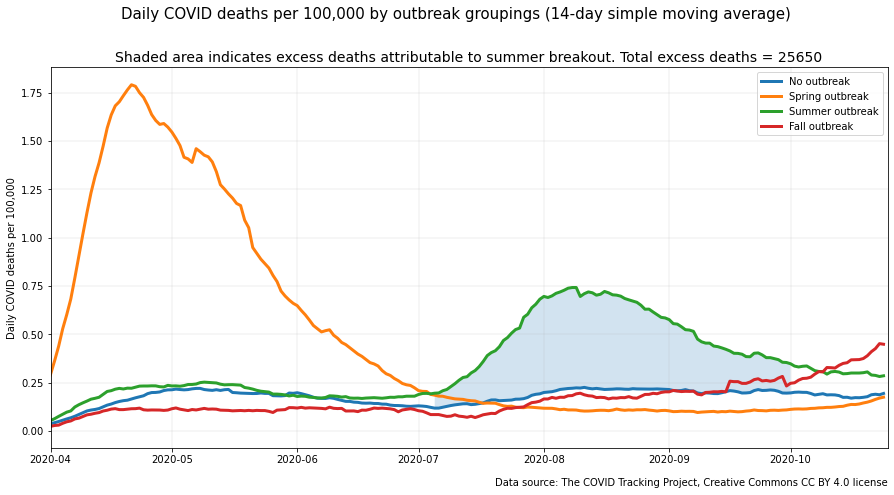

In [99]:
# Deaths per 100,000 by group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Daily COVID deaths per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1)
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    ax.plot(group_df['date'], group_df['death_SMA'] / group_df['Population'] * 100000, label = chart_group, lw=3) 

ax.set_title(f'Shaded area indicates excess deaths attributable to summer breakout. Total excess deaths = {summer_group_excess_deaths:.0f}', size=14)
ax.set_ylabel('Daily COVID deaths per 100,000')
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.fill_between(pd.date_range(datetime.date(2020, 7, 5),datetime.date(2020, 10, 1),freq='d'),
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['death_SMA'] / 
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['Population'].iloc[0] * 100000,
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['death_SMA'] / 
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['Population'].iloc[0] * 100000,
                alpha = 0.2 )
ax.legend()
plt.savefig('img/COVID-deaths-by-outbreak-groupings.png')

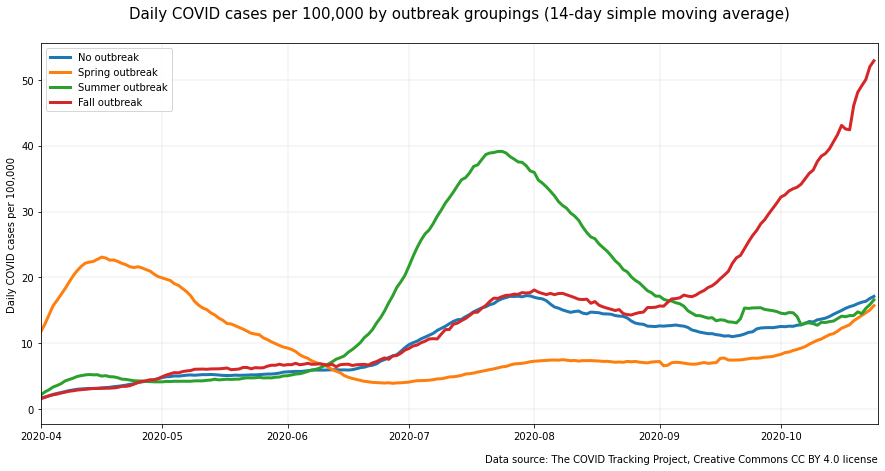

In [113]:
# Cases per 100,000 by group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
#     ax.bar(group_df['date'], group_df['positiveIncrease'] / group_df['Population'] * 100000, label = f'{chart_group} actuals',  alpha=0.25)
    ax.plot(group_df['date'], group_df['case_SMA'] / group_df['Population'] * 100000, label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_title(f'Daily COVID cases per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Daily COVID cases per 100,000')
ax.legend()

plt.savefig('img/COVID-cases-by-outbreak-groupings.png')

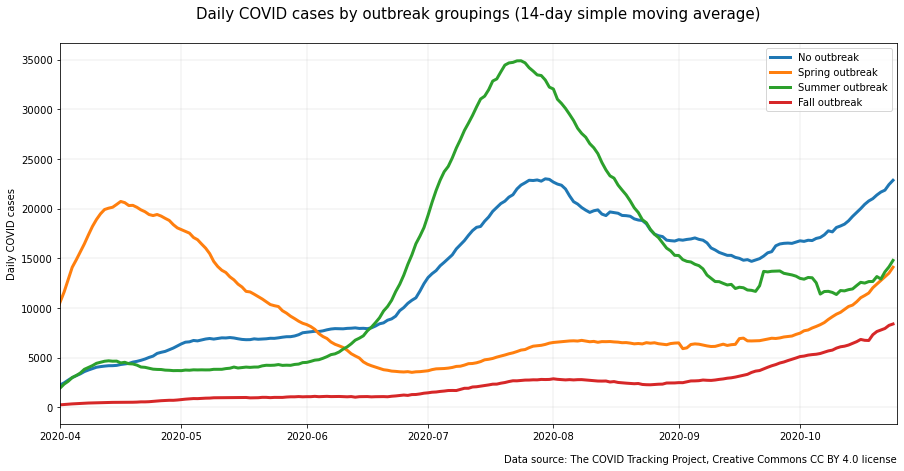

In [114]:
# Cases by group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
#     ax.bar(group_df['date'], group_df['positiveIncrease'], label = f'{chart_group} actuals', alpha=0.25)
    ax.plot(group_df['date'], group_df['case_SMA'], label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_title(f'Daily COVID cases by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Daily COVID cases')
ax.legend()

plt.savefig('img/COVID-total-cases-by-outbreak-groupings.png')

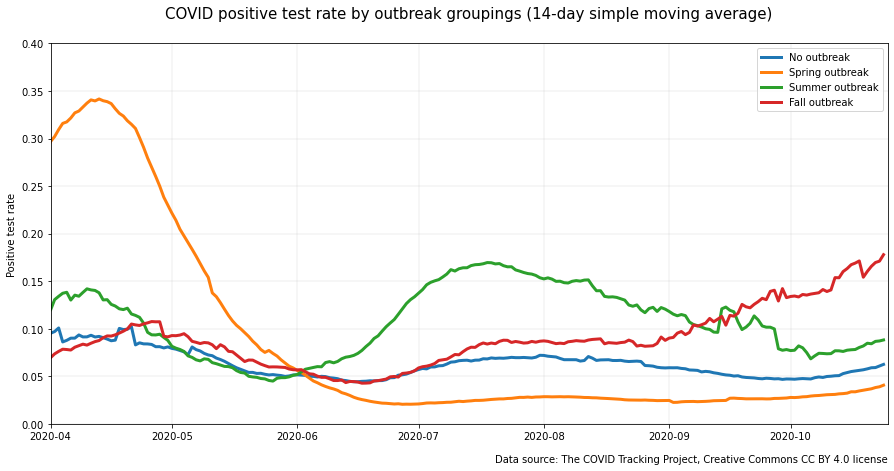

In [115]:
# Positivity rates by group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
#     ax.bar(group_df['date'], group_df['positiveIncrease'] / (group_df['positiveIncrease'] + group_df['negativeIncrease']), label = f'{chart_group} actuals',  alpha=0.25)
    ax.plot(group_df['date'], group_df['case_SMA'] / (group_df['case_SMA'] + group_df['negatives_SMA']), label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_ylim(0, 0.4)
ax.set_title(f'COVID positive test rate by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Positive test rate')
ax.legend()

plt.savefig('img/COVID-positive-test-rate-by-outbreak-groupings.png')

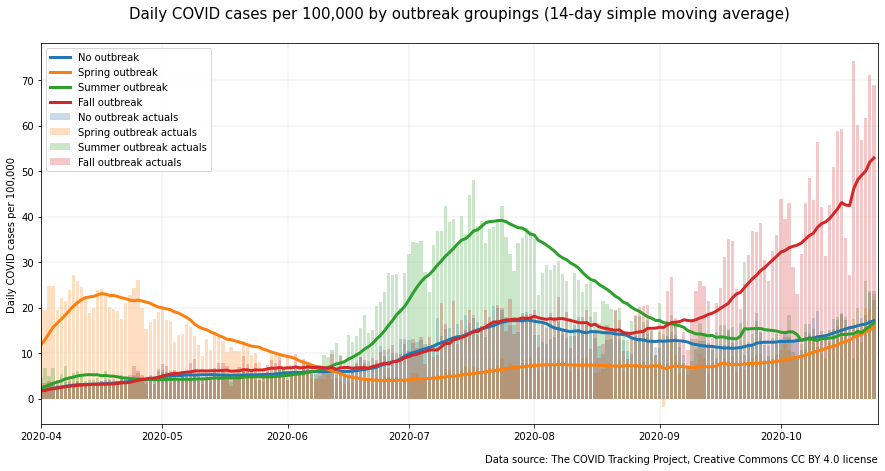

In [116]:
# Cases per 100,000 by group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    ax.bar(group_df['date'], group_df['positiveIncrease'] / group_df['Population'] * 100000, label = f'{chart_group} actuals',  alpha=0.25)
    ax.plot(group_df['date'], group_df['case_SMA'] / group_df['Population'] * 100000, label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_title(f'Daily COVID cases per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Daily COVID cases per 100,000')
ax.legend()

plt.savefig('img/COVID-cases-by-outbreak-groupings-showing-daily-variability.png')

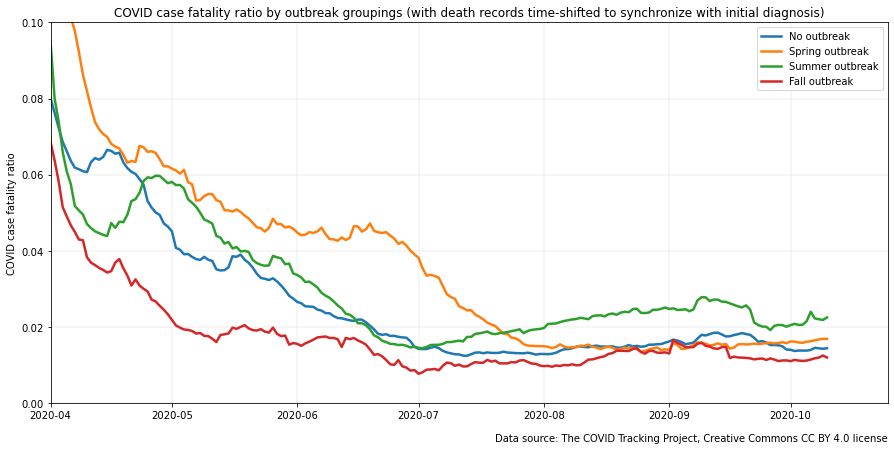

In [103]:
# Case fatality ratio by outbreak group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    temp_group_df = group_df[['date', 'death_SMA']]
    temp_group_df['date'] = temp_group_df['date'] - timedelta(days=14) # shifting death records by 14 days to sync with cases
    group_df = group_df.merge(temp_group_df, on='date')
    ax.plot(group_df['date'], group_df['death_SMA_y'] / group_df['case_SMA'], label = chart_group, lw=2.5)

ax.set_ylabel('COVID case fatality ratio')
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_ylim(0, 0.1)
ax.set_title(f'COVID case fatality ratio by outbreak groupings (with death records time-shifted to synchronize with initial diagnosis)')
ax.legend()
plt.savefig('img/COVID-case-fatality-by-outbreak-groupings.png')